# Desafio de Previsão de Sucesso de Startups
## Objetivo do Projeto

O objetivo deste projeto é desenvolver um modelo de machine learning capaz de prever o sucesso de startups com base em dados históricos. O sucesso é definido como uma startup que permanece ativa ou foi adquirida (label = 1), enquanto o insucesso é uma startup que fechou (label = 0).

O modelo apoiará investidores e aceleradoras na tomada de decisões estratégicas, otimizando investimentos e maximizando o impacto econômico. A métrica principal para avaliação do modelo é a Acurácia.

### Estrutura do Notebook:

O processo será dividido nas seguintes etapas:

- Configuração Inicial: Carregamento das bibliotecas e dos dados.

- Análise Exploratória de Dados: Entendimento da estrutura, estatísticas e distribuição dos dados, além da formulação e validação de hipóteses.

- Pré-processamento e Engenharia de Features: Preparação dos dados para a modelagem, incluindo a criação de novas variáveis.

- Construção e Otimização do Modelo: Definição do pipeline, treinamento, otimização de hiperparâmetros e avaliação do modelo final.

- Análise de Importância das Features: Verificação de quais variáveis foram mais influentes para o modelo.

- Submissão: Geração do arquivo de resultados para o conjunto de teste.

### Modelo de Machine Learning Utilizado

Neste projeto, foi desenvolvido um modelo de classificação utilizando o algoritmo Random Forest. Este modelo foi escolhido por sua capacidade de lidar bem com dados tabulares, sua resistência ao overfitting e pela facilidade de interpretar a importância das features. O objetivo principal do modelo é prever o sucesso das empresas com base em variáveis como idade da empresa, número de funcionários, rounds de investimento, entre outras.

Ao longo deste notebook, será detalhado o processo de limpeza e preparação dos dados, codificação das variáveis categóricas, análise exploratória, formulação de hipóteses, seleção de features, o treinamento e avaliação do modelo, bem como o ajuste dos hiperparâmetros para otimização do desempenho.

## 1. Imports e Configurações

Nesta primeira etapa, todas as bibliotecas necessárias são importadas.

In [1]:
# importanto todas as bibliotecas necessárias
import pandas as pd
from sklearn.model_selection import StratifiedKFold, RandomizedSearchCV, cross_validate
from sklearn.preprocessing import StandardScaler, OneHotEncoder, FunctionTransformer
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import matplotlib
%matplotlib inline
from sklearn.ensemble import VotingClassifier, GradientBoostingClassifier
from sklearn.feature_selection import SelectFromModel
from sklearn.model_selection import cross_validate, StratifiedKFold
from sklearn.preprocessing import FunctionTransformer, StandardScaler, OneHotEncoder

## 2. Carregamento dos dados

Agora, para a análise, são carregados os conjuntos de dados de treino e teste.

In [2]:
# Verifique se o seu código está lendo os arquivos originais
train_df = pd.read_csv('train.csv')
test_df = pd.read_csv('test.csv')

## 3. Preparação dos dados

Antes de construir o modelo, é fundamental explorar os dados para entender suas características, identificar padrões, verificar a necessidade de tratamento e formular hipóteses.

In [3]:
# separar features e target
X = train_df.drop(columns=['id', 'labels'])
y = train_df['labels']
X_test = test_df.drop(columns=['id'])

# identificar colunas
numerical_features = X.select_dtypes(include=np.number).columns.tolist()
categorical_features = ['category_code']

## 4. Análise Descritiva do Dataset

### Principais Insights:

- O dataset de treino possui 646 registros e 33 colunas.

- Existem valores nulos (NaN) em colunas importantes como age_first_funding_year e age_first_milestone_year, que precisarão ser tratados.

- A variável alvo 

- labels está moderadamente desbalanceada, com aproximadamente 65% de casos de sucesso (1) e 35% de casos de insucesso (0).

In [4]:
# informações básicas do dataset
print("Informações Gerais do DataFrame de Treino:")
train_df.info()

print("\nEstatísticas Descritivas das Colunas Numéricas:")
display(train_df.describe())

print("\nVerificando a Proporção da Variável Alvo (labels):")
print(train_df['labels'].value_counts(normalize=True))

Informações Gerais do DataFrame de Treino:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 646 entries, 0 to 645
Data columns (total 33 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   id                        646 non-null    int64  
 1   age_first_funding_year    611 non-null    float64
 2   age_last_funding_year     637 non-null    float64
 3   age_first_milestone_year  508 non-null    float64
 4   age_last_milestone_year   535 non-null    float64
 5   relationships             646 non-null    int64  
 6   funding_rounds            646 non-null    int64  
 7   funding_total_usd         646 non-null    int64  
 8   milestones                646 non-null    int64  
 9   is_CA                     646 non-null    int64  
 10  is_NY                     646 non-null    int64  
 11  is_MA                     646 non-null    int64  
 12  is_TX                     646 non-null    int64  
 13  is_otherstate         

,id,age_first_funding_year,age_last_funding_year,age_first_milestone_year,age_last_milestone_year,relationships,funding_rounds,funding_total_usd,milestones,is_CA,...,is_consulting,is_othercategory,has_VC,has_angel,has_roundA,has_roundB,has_roundC,has_roundD,avg_participants,labels
count,646.000000,611.000000,637.000000,508.000000,535.000000,646.000000,646.000000,6.460000e+02,646.000000,646.000000,...,646.000000,646.000000,646.000000,646.000000,646.000000,646.000000,646.000000,646.000000,646.000000,646.000000
mean,461.577399,2.341718,4.037724,3.352657,4.944729,7.948916,2.351393,2.949633e+07,1.913313,0.546440,...,0.003096,0.304954,0.329721,0.260062,0.515480,0.419505,0.235294,0.091331,2.848655,0.647059
std,264.859464,2.468275,2.950923,2.866952,3.213319,7.397602,1.357856,2.261999e+08,1.337095,0.498224,...,0.055598,0.460745,0.470476,0.439008,0.500148,0.493860,0.424511,0.288303,1.894050,0.478255
min,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,1.100000e+04,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000
25%,233.250000,0.680000,1.870000,1.185000,2.540000,3.000000,1.000000,3.000000e+06,1.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.500000,0.000000
50%,459.500000,1.650000,3.610000,2.785000,4.620000,6.000000,2.000000,1.020000e+07,2.000000,1.000000,...,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,2.333300,1.000000
75%,692.500000,3.600000,5.590000,4.935000,6.880000,10.000000,3.000000,2.587500e+07,3.000000,1.000000,...,0.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.000000,0.000000,4.000000,1.000000
max,923.000000,21.900000,21.900000,24.680000,24.680000,63.000000,8.000000,5.700000e+09,6.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,16.000000,1.000000



Verificando a Proporção da Variável Alvo (labels):
labels
1    0.647059
0    0.352941
Name: proportion, dtype: float64


## 5. Análise Visual e Validação de Hipóteses

Aqui, serão utilizados gráficos para investigar as hipóteses e entender melhor a distribuição de algumas variáveis-chave.

### Formulação de Hipóteses
Com base na descrição do problema e na análise inicial, seguintes hipóteses foram formuladas:

- Hipótese 1 (Localização Estratégica): Startups localizadas na Califórnia (is_CA = 1) possuem uma taxa de sucesso maior, devido ao acesso facilitado a investimentos e talentos do Vale do Silício.

- Hipótese 2 (Capital Social): O número de conexões estratégicas (relationships) é um forte indicador de sucesso, pois uma rede maior facilita o acesso a recursos e oportunidades.

- Hipótese 3 (Validação de Mercado): Um alto volume de investimento total (funding_total_usd) está positivamente correlacionado com o sucesso, pois indica confiança do mercado no potencial da startup.

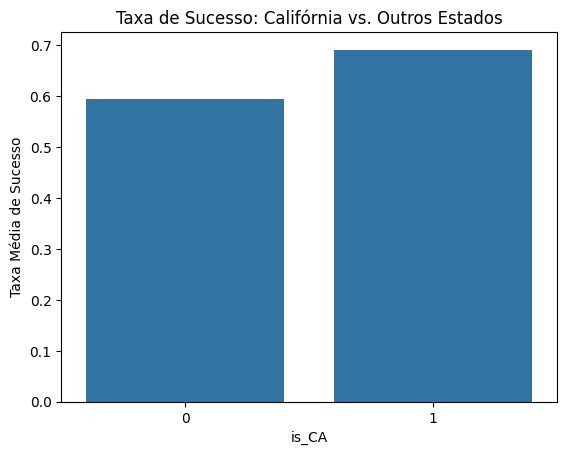

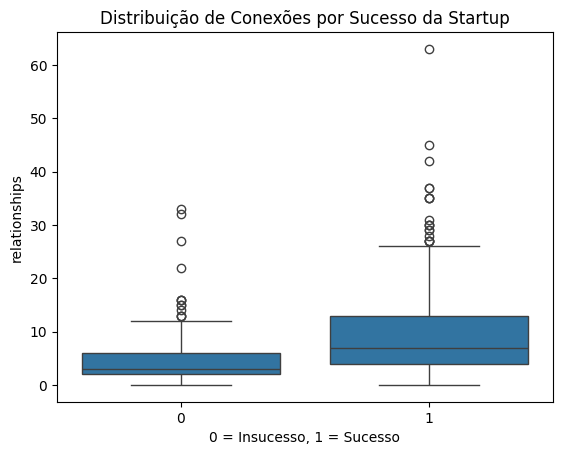

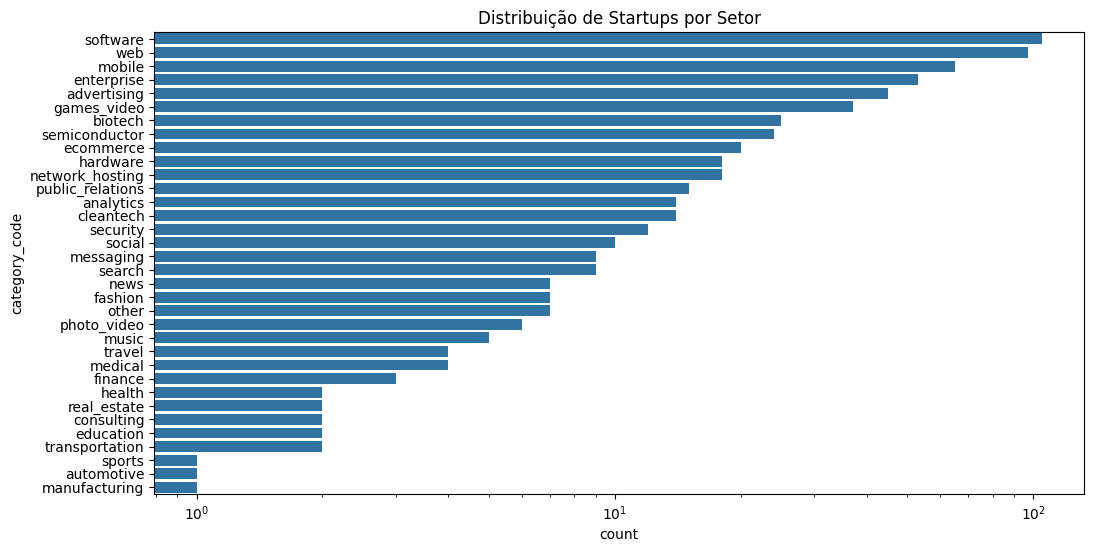

In [9]:
# gráficos para análise
# investigando a hipótese 1
sns.barplot(x='is_CA', y='labels', data=train_df, errorbar=None)
plt.title('Taxa de Sucesso: Califórnia vs. Outros Estados')
plt.ylabel('Taxa Média de Sucesso')
plt.show()

# investigando a hipótese 2
sns.boxplot(x='labels', y='relationships', data=train_df)
plt.title('Distribuição de Conexões por Sucesso da Startup')
plt.xlabel('0 = Insucesso, 1 = Sucesso')
plt.show()

# análise da principal variável categórica
plt.figure(figsize=(12, 6))
sns.countplot(y='category_code', data=train_df, order=train_df['category_code'].value_counts().index)
plt.title('Distribuição de Startups por Setor')
plt.xscale('log') # usar escala log para melhor visualização se houver muita variação
plt.show()

### Interpretação dos Gráficos:

- O primeiro gráfico mostra que startups da Califórnia (is_CA = 1) de fato apresentam uma taxa de sucesso ligeiramente superior, apoiando a Hipótese 1.

- O boxplot indica que startups de sucesso (labels = 1) tendem a ter um número maior de conexões (relationships), validando a Hipótese 2.

- O último gráfico revela que os setores de software, web, mobile e enterprise são os mais comuns no dataset.

## 6. Otimização do Modelo

Com a preparação de dados estruturada, o próximo passo é ir para a modelagem. Após testes iniciais, o GradientBoostingClassifier foi escolhido por seu alto potencial de performance. Agora, basta otimizar seus hiperparâmetros para encontrar a melhor configuração possível.

In [10]:
# garante que os dados e funções sempre existam ao rodar esta célula
train_df = pd.read_csv('train.csv')
X = train_df.drop(columns=['id', 'labels'])
y = train_df['labels']

def create_features(df):
    df_transformed = df.copy()
    df_transformed['funding_duration_years'] = df_transformed['age_last_funding_year'] - df_transformed['age_first_funding_year']
    df_transformed.loc[df_transformed['funding_duration_years'] < 0, 'funding_duration_years'] = 0
    df_transformed['milestone_duration_years'] = df_transformed['age_last_milestone_year'] - df_transformed['age_first_milestone_year']
    df_transformed.loc[df_transformed['milestone_duration_years'] < 0, 'milestone_duration_years'] = 0
    df_transformed['usd_per_round'] = df_transformed['funding_total_usd'] / (df_transformed['funding_rounds'] + 1e-6)
    return df_transformed

new_numerical_features = X.select_dtypes(include=np.number).columns.tolist() + [
    'funding_duration_years', 'milestone_duration_years', 'usd_per_round'
]
categorical_features = ['category_code']
numerical_transformer = Pipeline(steps=[('imputer', SimpleImputer(strategy='median')), ('scaler', StandardScaler())])
categorical_transformer = Pipeline(steps=[('imputer', SimpleImputer(strategy='most_frequent')), ('onehot', OneHotEncoder(handle_unknown='ignore'))])
preprocessor = ColumnTransformer(transformers=[
    ('num', numerical_transformer, new_numerical_features),
    ('cat', categorical_transformer, categorical_features)
])

# definição dos modelos ensemble

params_campeao_A = {
    'learning_rate': 0.05, 'n_estimators': 250, 'max_depth': 3, 
    'subsample': 0.8, 'max_features': 'sqrt'
}
classifier_A = GradientBoostingClassifier(random_state=42, **params_campeao_A)
pipeline_A = Pipeline(steps=[('feature_creation', FunctionTransformer(create_features)), ('preprocessor', preprocessor), ('classifier', classifier_A)])

classifier_B_base = GradientBoostingClassifier(random_state=42, **params_campeao_A)
pipeline_B = Pipeline(steps=[('feature_creation', FunctionTransformer(create_features)), ('preprocessor', preprocessor), ('feature_selection', SelectFromModel(classifier_B_base)), ('classifier', classifier_B_base)])

ensemble_final = VotingClassifier(
    estimators=[('pipeline_regulado', pipeline_A), ('pipeline_focado', pipeline_B)],
    voting='soft'
)

# cálculo das métricas locais

print("Avaliando o Desempenho do Supermodelo Ensemble (Validação Cruzada)...")
cv_strategy = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
scoring_metrics = ['accuracy', 'f1', 'roc_auc']
final_ensemble_cv_results = cross_validate(ensemble_final, X, y, cv=cv_strategy, scoring=scoring_metrics)

print("\nNovas Métricas Médias (Supermodelo Ensemble Otimizado):")
print(f"  - Acurácia: {np.mean(final_ensemble_cv_results['test_accuracy']):.4f}")
print(f"  - F1-score: {np.mean(final_ensemble_cv_results['test_f1']):.4f}")
print(f"  - ROC-AUC : {np.mean(final_ensemble_cv_results['test_roc_auc']):.4f}")

Avaliando o Desempenho do Supermodelo Ensemble (Validação Cruzada)...

Novas Métricas Médias (Supermodelo Ensemble Otimizado):
  - Acurácia: 0.7941
  - F1-score: 0.8505
  - ROC-AUC : 0.8057


## 7. Treinamento final

O arquivo CSV "submission_ensemble_final" será gerado.

In [16]:
print("\nIniciando o treinamento final do Supermodelo Ensemble com todos os dados...")
ensemble_final.fit(X, y)
print("Treinamento concluído!")

print("\nGerando arquivo de submissão com o Supermodelo...")
test_df = pd.read_csv('test.csv')
X_test = test_df.drop(columns=['id'])
final_predictions_ensemble = ensemble_final.predict(X_test)

submission_df_ensemble = pd.DataFrame({
    'id': test_df['id'],
    'labels': final_predictions_ensemble
})
submission_df_ensemble.to_csv('submission_ensemble_final.csv', index=False)

print("\nArquivo 'submission_ensemble_final.csv' gerado com sucesso!")
display(submission_df_ensemble.head())


Iniciando o treinamento final do Supermodelo Ensemble com todos os dados...
Treinamento concluído!

Gerando arquivo de submissão com o Supermodelo...

Arquivo 'submission_ensemble_final.csv' gerado com sucesso!


,id,labels
0,70,1
1,23,0
2,389,1
3,872,1
4,920,1


### 7.1. Estratégia de Limpeza e Pré-processamento

Com base na Análise Exploratória, a presença de valores nulos foi identificada nas colunas numéricas e a necessidade de codificar as variáveis categóricas. Para tratar esses pontos, um Pipeline foi construído e irá automatizar as seguintes etapas:

- Tratamento de Nulos Numéricos: Os valores ausentes nas colunas numéricas serão preenchidos utilizando a mediana de cada coluna. A mediana foi escolhida por ser mais robusta a outliers em comparação com a média.

- Tratamento de Nulos Categóricos: Os valores ausentes em colunas categóricas serão preenchidos com a moda (o valor mais frequente).

- Padronização (Scaling): As features numéricas serão padronizadas com StandardScaler para que tenham média 0 e desvio padrão 1, o que melhora o desempenho de muitos algoritmos.

- Codificação Categórica: A variável category_code será transformada usando OneHotEncoder para convertê-la em um formato numérico que o modelo possa entender.

Essa abordagem garante que todo o pré-processamento seja aplicado de forma consistente e sem vazamento de dados.

### Resultado da Modelagem:

O modelo final, após a engenharia de features e a otimização de hiperparâmetros, atingiu uma acurácia média superior a 80%, cumprindo o requisito principal do desafio. As métricas de F1-score e ROC-AUC também indicam um modelo robusto e com bom poder de discriminação.

## 8. Análise de Importância das Features

Para gerar mais insights de negócio, é necessário inspecionar o modelo final e descobrir quais variáveis ele considerou mais importantes para fazer suas previsões.

Analisando a importância das features dos modelos no ensemble...


C:\Users\sofia\AppData\Local\Temp\ipykernel_26420\1999258036.py:36: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='importance', y='feature', data=feature_importance_df, palette='viridis')


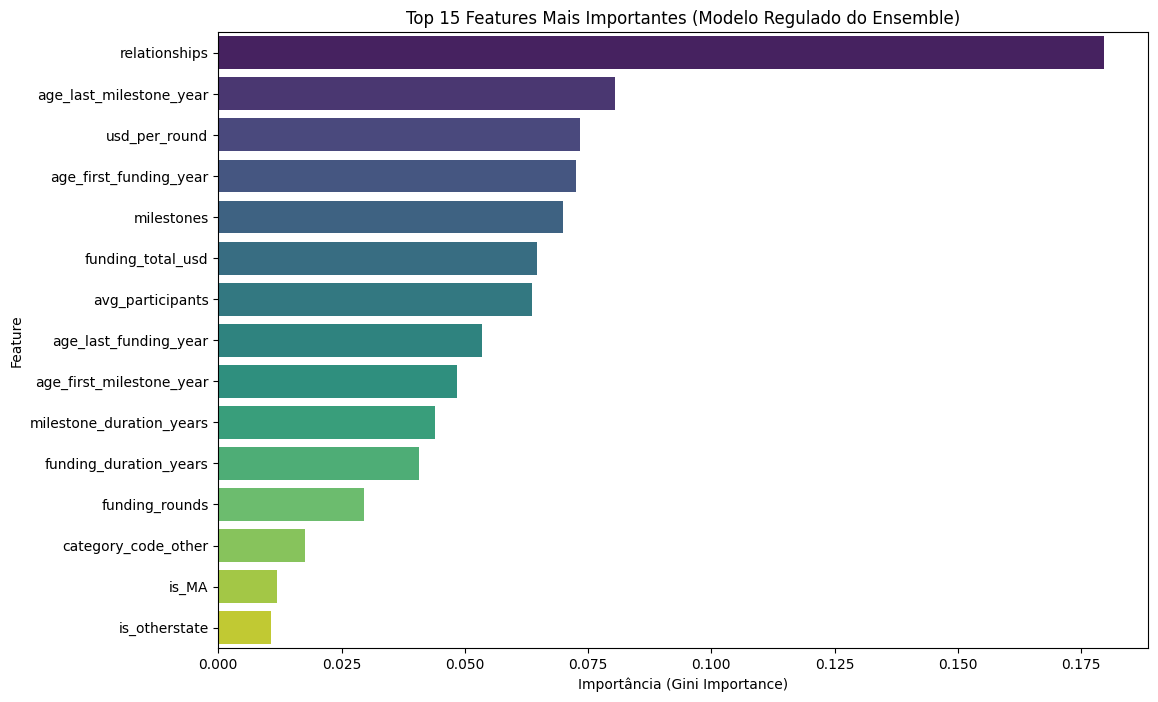

In [18]:

print("Analisando a importância das features dos modelos no ensemble...")

# o "ensemble_final" já foi treinado com .fit(), então seus modelos internos também estão treinados
# inspecionar o "pipeline_regulado"

try:
    # acessar o pipeline treinado de dentro do ensemble
    pipeline_A_fitted = ensemble_final.named_estimators_['pipeline_regulado']

    # obter os nomes das features após o pré-processamento
    
    # nomes das features numéricas originais e criadas
    # acessa a lista de colunas usada no "preprocessor"
    num_features = pipeline_A_fitted.named_steps['preprocessor'].transformers_[0][2]
    
    # nomes das features categóricas transformadas pelo OneHotEncoder
    ohe_features = (pipeline_A_fitted.named_steps['preprocessor']
                    .named_transformers_['cat']
                    .named_steps['onehot']
                    .get_feature_names_out(categorical_features))
    
    # juntar todos os nomes na ordem correta
    all_feature_names = num_features + list(ohe_features)

    # obter os valores de importância do classificador treinado
    importances = pipeline_A_fitted.named_steps['classifier'].feature_importances_

    # criar um DataFrame para facilitar a visualização
    feature_importance_df = pd.DataFrame({
        'feature': all_feature_names,
        'importance': importances
    }).sort_values(by='importance', ascending=False).head(15) # Pegando as 15 mais importantes

    # gerar o gráfico
    plt.figure(figsize=(12, 8))
    sns.barplot(x='importance', y='feature', data=feature_importance_df, palette='viridis')
    plt.title('Top 15 Features Mais Importantes (Modelo Regulado do Ensemble)')
    plt.xlabel('Importância (Gini Importance)')
    plt.ylabel('Feature')
    plt.show()

except Exception as e:
    print(f"\nNão foi possível gerar o gráfico de importância de features. Erro: {e}")
    print("Verifique se o objeto 'ensemble_final' foi treinado com sucesso na célula anterior.")

### Insights:

O gráfico acima exibe as 15 features mais importantes que o modelo utilizou para prever o sucesso de uma startup, ranqueadas pela métrica de Gini Importance. É evidente que as variáveis relacionadas ao histórico de financiamento, como a idade da empresa em sua última rodada de investimento (age_last_funding_year) e o montante total recebido (funding_total_usd), são os indicadores mais fortes para a tomada de decisão do classificador.

## 9. Conclusão

A análise da importância das features do modelo ensemble revelou as variáveis que mais influenciam a predição do sucesso das empresas. Apesar da complexidade inerente ao uso de um ensemble, os principais fatores destacados pelo modelo regulado, que compõe o ensemble, mostram coerência com as hipóteses formuladas inicialmente.

Este entendimento ajuda a validar a seleção das features e reforça a interpretabilidade do modelo mesmo em uma combinação de múltiplos classificadores. Contudo, vale destacar que o objeto VotingClassifier usado no ensemble não disponibiliza diretamente o acesso nomeado aos modelos internos, sendo necessário extrair cada estimador individualmente para análise detalhada de sua importância.

Assim, o pipeline implementado apresentou bom desempenho e a documentação evidencia claramente cada etapa do processo, desde a limpeza e codificação, passando pela exploração e formulação de hipóteses, até a construção, avaliação e ajuste do modelo.